Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: [Dies Natalis Solis Invicti](https://en.wikipedia.org/wiki/Sol_Invictus)
* Reviews: [Befana](https://en.wikipedia.org/wiki/Befana)

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

### class TicTacToe():
Represents the game of Tic-Tac-Toe.
Uses a one-dimensional NumPy array to represent the game board, with a mask for players X and O.
Contains methods for making a move, checking for a winner, and printing the current state.

### class Player():
An abstract class representing a player.
Contains methods for making a move, updating based on game results, and loading/saving agents.

### class RandomPlayer(Player):
Inherits from the Player class.
Implements a random move strategy.

### class ReinforcedPlayer(Player):
Inherits from the Player class.
Implements a player using reinforcement learning.
Uses Q-learning with a trade-off between exploration and exploitation.

### class MinimaxPlayer(Player):
Inherits from the Player class.
Implements a player using the minimax algorithm.
The minimax algorithm explores all possible moves and outcomes, selecting the move that minimizes the opponent's maximum gain while maximizing its own.



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import combinations
from enum import Enum, IntEnum
import random
import pickle
from tqdm import tqdm

Tic_Tac = namedtuple("Tic_Tac", "row, column")

class TicTacToe():

    class PlayerResult(IntEnum):
        X = 0
        O = 1
        Empty = -1
        Draw = 2

    def __init__(self, player=PlayerResult.X):
        self.board = np.zeros(9)
        self.mask = np.array([4, 9, 2, 3, 5, 7, 8, 1, 6])
        if player == TicTacToe.PlayerResult.X:
            self.current_player = 1
        else:
            self.current_player = -1
        self.winner = TicTacToe.PlayerResult.Empty

    def move(self, position: Tic_Tac) -> bool:
        position = position.row * 3 + position.column
        if self.board[position] == 0:
            self.board[position] = self.current_player * self.mask[position]
            self.current_player = -self.current_player
            return True
        else:
            return False

    def win(elements: list) -> bool:
        return any(sum(combination) == 15 for combination in combinations(elements, 3))

    def possible_moves(self) -> list:
        return [Tic_Tac(i // 3, i % 3) for i in range(9) if self.board[i] == 0]

    def check_finished(self) -> bool:
        if np.sum(self.board == 0) == 0 or self.check_winner() != 0:
            return True
        else:
            return False
    
    def copy(self):
        new_game = TicTacToe()
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        new_game.winner = self.winner
        return new_game

    def check_winner(self) -> PlayerResult:
        player_1 = self.board[self.board > 0]
        player_2 = abs(self.board[self.board < 0])
        if TicTacToe.win(player_1):
            self.winner = TicTacToe.PlayerResult.X
        elif TicTacToe.win(player_2):
            self.winner = TicTacToe.PlayerResult.O
        elif np.sum(self.board == 0) == 0:
            self.winner = TicTacToe.PlayerResult.Draw
        else:
            self.winner = TicTacToe.PlayerResult.Empty

        return self.winner

    def print_winner(self) -> str:
        if self.winner == TicTacToe.PlayerResult.X:
            return "Player X"
        elif self.winner == TicTacToe.PlayerResult.O:
            return "Player O"
        elif self.winner == TicTacToe.PlayerResult.Draw:
            return "Draw"
        else:
            return "Game not finished"

    def __str__(self):
        return f"Player to move: {self.current_player}" + "\n" + str(self.board.reshape(3, 3))

    def __repr__(self):
        return str(self.board)

class Player():
    def __init__(self, k=None):
        self.k = k

    def play(self, board: np.array) -> Tic_Tac:
        pass

    def update(self, result: bool):
        pass

    def __str__(self):
        return f"Player {self.__class__.__name__}"

    def load_agent(self, path):
        with open(path, 'rb') as f:
            self = pickle.load(f)
        return self

    def save_agent(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

class RandomPlayer(Player):
    def __init__(self):
        super().__init__()

    def play(self, board: TicTacToe) -> Tic_Tac:
        possible_moves = board.possible_moves()
        move = possible_moves[np.random.randint(len(possible_moves))]
        return move

class HumanPlayer(Player):
    def __init__(self):
        super().__init__()

    def play(self, board: TicTacToe) -> Tic_Tac:
        possible_moves = board.possible_moves()
        print("Possible moves : ", possible_moves)
        
        while True:
            try:
                row = int(input("Row : "))
                column = int(input("Column : "))
                move = Tic_Tac(row, column)

                if move in possible_moves:
                    return move
                else:
                    print("Invalid move. Please try again.")
            except ValueError:
                print("Invalid input. Please enter valid row and column.")

class MinimaxPlayer(Player):
   def play(self, game):
       best_score = float('-inf')
       best_move = None

       for move in game.possible_moves():
           game_copy = game.copy()
           game_copy.move(move)
           score = self.minimax(game_copy, False, float('-inf'), float('inf'))
           
           if score > best_score:
               best_score = score
               best_move = move

       return best_move

   def minimax(self, game, is_maximizing, alpha, beta):
       if game.check_winner() == TicTacToe.PlayerResult.X:
           return -1
       elif game.check_winner() == TicTacToe.PlayerResult.O:
           return 1
       elif game.check_winner() == TicTacToe.PlayerResult.Draw:
           return 0

       if is_maximizing:
           best_score = float('-inf')
           for move in game.possible_moves():
               game_copy = game.copy()
               game_copy.move(move)
               score = self.minimax(game_copy, False, alpha, beta)
               best_score = max(score, best_score)
               alpha = max(alpha, best_score)
               if beta <= alpha:
                  break
           return best_score
       else:
           best_score = float('inf')
           for move in game.possible_moves():
               game_copy = game.copy()
               game_copy.move(move)
               score = self.minimax(game_copy, True, alpha, beta)
               best_score = min(score, best_score)
               beta = min(beta, best_score)
               if beta <= alpha:
                  break
           return best_score




class ReinforcedPlayer(Player):
    def __init__(self, k: int = 0.1, epsilon: float = 0.1, alpha: float = 0.1, gamma: float = 0.9):
        super().__init__(k)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Q = dict()
        self.state = None
        self.action = None
        self.sequence = []
        self.used_moves = 0
        self.wins = 0
        self.learning = True

    def play(self, game: TicTacToe) -> Tic_Tac:
        if game.current_player == 1:
            self.state = tuple(game.board)
        else:
            self.state = tuple(-game.board)
        if self.state not in self.Q:
            self.Q[self.state] = {move: random.uniform(0, 1) for move in game.possible_moves()}
            self.action = max(self.Q[self.state], key=lambda k: self.Q[self.state][k])
        else:
            if random.uniform(0, 1) < self.epsilon:
                self.action = random.choice(list(self.Q[self.state].keys()))
            else:
                self.action = max(self.Q[self.state], key=lambda k: self.Q[self.state][k])
                self.used_moves += 1
        if self.learning:
            self.sequence.append((self.state, self.action))
        return self.action
    
    def update(self, reward: int) -> None:
        for state, action in reversed(self.sequence):
            if len(self.sequence) == 3 and reward == 1:
                self.Q[state][action] = min(1, self.Q[state][action] + self.alpha * (2 * reward * self.Q[state][action]))
            elif reward == 1:
                self.Q[state][action] = min(1, self.Q[state][action] + self.alpha * (reward * self.Q[state][action]))
            else:
                self.Q[state][action] = max(0, self.Q[state][action] + self.alpha * (2 * reward * self.Q[state][action]))
            reward = reward * self.gamma
        self.sequence = []

    def stop_learning(self):
        self.learning = False
        self.epsilon = 0










In [9]:
class GameResults(Enum):
    Win = 1
    Loss = -2
    Draw = -0.5

TRAINING
Simulate the training of two players, RandomPlayer and ReinforcedPlayer, in 100,000 Tic-Tac-Toe matches. During training, ReinforcedPlayer learns through reinforcement learning, updating its Q-values. Every 1000 matches, print some statistics such as the number of moves used, the number of states in ReinforcedPlayer's model, and the winning percentage of ReinforcedPlayer.

After training, display the final statistics, including the overall winning percentage of ReinforcedPlayer. Finally, show a graph depicting how ReinforcedPlayer's winning percentage changes throughout training. Lastly, set ReinforcedPlayer to "stop learning" mode, preventing further updates to the model.

Player X : Player RandomPlayer
Player O : Player ReinforcedPlayer


435 already tried moves used with 1702 states with epsilon 0.8
Wins :  46.0 %
1141 already tried moves used with 2598 states with epsilon 0.752
Wins :  45.5 %
2059 already tried moves used with 3153 states with epsilon 0.70688
Wins :  50.8 %
3208 already tried moves used with 3513 states with epsilon 0.6644671999999999
Wins :  49.0 %
4502 already tried moves used with 3782 states with epsilon 0.6245991679999999
Wins :  49.5 %
5988 already tried moves used with 3946 states with epsilon 0.5871232179199999
Wins :  54.2 %
7646 already tried moves used with 4066 states with epsilon 0.5518958248447998
Wins :  52.0 %
9445 already tried moves used with 4142 states with epsilon 0.5187820753541118
Wins :  54.800000000000004 %
11325 already tried moves used with 4203 states with epsilon 0.4876551508328651
Wins :  58.599999999999994 %
13321 already tried moves used with 4251 states with epsilon 0.45839584178289317
Wins :  57.8 %
15447 already tried moves used with 4308 states with epsilon 0.430892

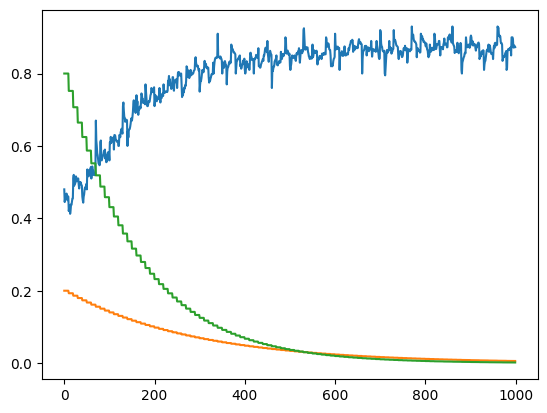

In [10]:
wins = [0,0,0]
started = [0,0]
perc = []
player = [RandomPlayer(), ReinforcedPlayer(epsilon=0.8, alpha=0.2, gamma=0.7)]
print(f"Player X : {player[0]}")
print(f"Player O : {player[1]}")
for rep in range(100_000):
    
    i = random.randint(0,1) # random player starts
    started[i] += 1
    game = TicTacToe(player=TicTacToe.PlayerResult(i))
    # play the game
    while game.check_winner() == TicTacToe.PlayerResult.Empty:
        game.move(player[i].play(game))
        i = 1 - i
    winner = game.check_winner()
    wins[int(winner)] += 1
    if winner != TicTacToe.PlayerResult.Draw:
        player[int(winner)].update(GameResults.Win.value)
        
        player[int(1-winner)].update(GameResults.Loss.value)
    else:
        player[0].update(GameResults.Draw.value)
        player[1].update(GameResults.Draw.value)
    
    if (rep + 1) % 1000  == 0:
        print(f"{player[1].used_moves} already tried moves used with {player[1].Q.__len__()} states with epsilon {player[1].epsilon}")
        print("Wins : ", wins[1] / (sum(wins)) * 100 , "%")
        perc.append((wins[1] / (sum(wins)) , player[1].alpha, player[1].epsilon ))
        player[1].epsilon *= 0.94
        player[1].alpha *= 0.965
        wins = [0,0,0]
    elif (rep + 1) % 100  == 0:
        perc.append((wins[1] / (sum(wins)) , player[1].alpha, player[1].epsilon ))
    
print("Wins : ", wins[1] / (rep) , "\nDraws : ", wins[2])
print("Started : ", started)
print(f"Q states : {player[1].Q}")

plt.plot(perc)
main_player = player[1]
main_player.stop_learning()

The MinimaxPlayer is a strategic player that employs the minimax algorithm for decision-making. This algorithm explores all possible moves and outcomes in the game tree, assuming that both players play optimally. It recursively evaluates the possible outcomes and selects the move that minimizes the potential loss or maximizes the gain, considering the opponent's best possible response. The MinimaxPlayer is a powerful strategy for Tic-Tac-Toe, ensuring that it either wins or forces a draw when playing against an optimal opponent.
It's not surprising that a ReinforcedPlayer might struggle to consistently win against a MinimaxPlayer in Tic-Tac-Toe.
It takes a long time, and the reinforced agent rarely manages to win, but rather to draw.

In [20]:
player = [ReinforcedPlayer(epsilon=0.9, alpha=0.5, gamma=0.9), MinimaxPlayer()]
wins = [0,0,0]
started = [0,0]
perc = []
print(f"Player O : {player[1]}")
print(f"Player X : {player[0]}")

for rep in range(1000):
    
    i = 1 - i  # switch players each round
    started[i] += 1
    game = TicTacToe(player=TicTacToe.PlayerResult(i))
    
    print(f"Current player: {player[i]}")
    
    # play the game
    while game.check_winner() == TicTacToe.PlayerResult.Empty:
        move = player[i].play(game)
        print(f"Player {player[i]} plays {move}")
        game.move(move)
        i = 1 - i
    print("Game finished")
    winner = game.check_winner()
    wins[int(winner)] += 1
    if winner != TicTacToe.PlayerResult.Draw:
        player[int(winner)].update(GameResults.Win.value)
        player[int(1-winner)].update(GameResults.Loss.value)
    else:
        player[0].update(GameResults.Draw.value)
        player[1].update(GameResults.Draw.value)

    if (rep + 1) % 1000 == 0:
        print(f"{player[0].used_moves} already tried moves used with {player[0].Q.__len__()} states with epsilon {player[0].epsilon}")
        print("Wins : ", wins[0] / (sum(wins)) * 100, "%")
        perc.append((wins[0] / (sum(wins)), player[0].alpha, player[0].epsilon))
        player[0].epsilon *= 0.94
        player[0].alpha *= 0.965
        wins = [0, 0, 0]
    elif (rep + 1) % 100 == 0:
        perc.append((wins[0] / (sum(wins)), player[0].alpha, player[0].epsilon))




print("Wins : ", wins[0] / (rep), "\nDraws : ", wins[2])
print("Started : ", started)
print(f"Q states : {player[0].Q}")

plt.plot(perc)
main_player = player[0]
main_player.stop_learning()





Player O : Player MinimaxPlayer
Player X : Player ReinforcedPlayer
Current player: Player ReinforcedPlayer
Player Player ReinforcedPlayer plays Tic_Tac(row=1, column=0)
Player Player MinimaxPlayer plays Tic_Tac(row=0, column=0)
Player Player ReinforcedPlayer plays Tic_Tac(row=1, column=2)
Player Player MinimaxPlayer plays Tic_Tac(row=1, column=1)
Player Player ReinforcedPlayer plays Tic_Tac(row=0, column=2)
Player Player MinimaxPlayer plays Tic_Tac(row=2, column=2)
Game finished
Current player: Player MinimaxPlayer
Player Player MinimaxPlayer plays Tic_Tac(row=0, column=0)
Player Player ReinforcedPlayer plays Tic_Tac(row=2, column=2)
Player Player MinimaxPlayer plays Tic_Tac(row=0, column=2)
Player Player ReinforcedPlayer plays Tic_Tac(row=0, column=1)
Player Player MinimaxPlayer plays Tic_Tac(row=2, column=0)
Player Player ReinforcedPlayer plays Tic_Tac(row=1, column=0)
Player Player MinimaxPlayer plays Tic_Tac(row=1, column=1)
Game finished
Current player: Player MinimaxPlayer
Player

Simulate a complete Tic-Tac-Toe match between a player trained through reinforcement learning (main_player) and a random player (RandomPlayer). Print the Q-values of the trained player during the game and the final result of the match.

In [13]:
board = TicTacToe()
print(board)
i = random.randint(0,1) # random player starts
while board.check_winner() == TicTacToe.PlayerResult.Empty:
    if i == 0:
        if tuple(board.board) in main_player.Q:
            #print(main_player.Q[tuple(board.board)])
            for key  in main_player.Q[tuple(board.board)]:
                print(key , " : ", main_player.Q[tuple(board.board)][key])
        else:
            print("Not in Q")
        board.move(main_player.play(board))
        print(board)
    else:
        board.move(RandomPlayer().play(board))
        print(board)
    i = 1 - i
print(board.print_winner())
    

Player to move: 1
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Player to move: -1
[[0. 9. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Not in Q
Player to move: 1
[[ 0.  9.  0.]
 [ 0.  0. -7.]
 [ 0.  0.  0.]]
Player to move: -1
[[ 0.  9.  2.]
 [ 0.  0. -7.]
 [ 0.  0.  0.]]
Not in Q
Player to move: 1
[[ 0.  9.  2.]
 [ 0.  0. -7.]
 [-8.  0.  0.]]
Player to move: -1
[[ 0.  9.  2.]
 [ 0.  0. -7.]
 [-8.  0.  6.]]
Not in Q
Player to move: 1
[[ 0.  9.  2.]
 [-3.  0. -7.]
 [-8.  0.  6.]]
Player to move: -1
[[ 0.  9.  2.]
 [-3.  0. -7.]
 [-8.  1.  6.]]
Not in Q
Player to move: 1
[[ 0.  9.  2.]
 [-3. -5. -7.]
 [-8.  1.  6.]]
Player O


Simulate a series of matches between a trained player (main_player) and a random player (RandomPlayer) after main_player has stopped learning. Record the number of victories for each player and the number of tied matches.

In [14]:
main_player.stop_learning()

wins = [0,0,0]
started = [0,0]
player = [main_player, RandomPlayer()]
print(f"Player X : {player[0]}")
print(f"Player O : {player[1]}")
for rep in range(1000):
    
    i = random.randint(0,1)
    started[i] += 1
    game = TicTacToe(player=TicTacToe.PlayerResult(i))
    while game.check_winner() == TicTacToe.PlayerResult.Empty:
        game.move(player[i].play(game))
        i = 1 - i
    winner = game.check_winner()
    wins[int(winner)] += 1
print("Wins : ", wins[:2] , "\nDraws : ", wins[2])

Player X : Player ReinforcedPlayer
Player O : Player RandomPlayer
Wins :  [478, 385] 
Draws :  137


In [16]:
main_player.save_agent("q_aqent.pkl")

Simulate a complete Tic-Tac-Toe match between a player trained through reinforcement learning (main_player) and a human player (HumanPlayer).

In [17]:
def print_board(game):
    for i in range(3):
        for j in range(3):
            position = i * 3 + j
            if game.board[position] > 0:
                print('X', end=' ')  # Human Player's move
            elif game.board[position] < 0:
                print('O', end=' ')  # Reinforced Player's move
            else:
                print('.', end=' ')
        print()


board = TicTacToe()
main_player.stop_learning()

player = [main_player, HumanPlayer()]  
print(f"Player X : {player[0]}")
print(f"Player O : {player[1]}")

game = TicTacToe(player=TicTacToe.PlayerResult.X)  # Il main player stars  'X'


while game.check_winner() == TicTacToe.PlayerResult.Empty:
    
    print_board(game)
    game.move(player[0].play(game)) 
   

    if game.check_winner() != TicTacToe.PlayerResult.Empty:
        break  

    
    print_board(game)
    game.move(player[1].play(game))  # Human Player makes move 'O'
    

print("\nFinal Board:")
print_board(game)
print(game.print_winner())


Player X : Player ReinforcedPlayer
Player O : Player HumanPlayer
. . . 
. . . 
. . . 
X . . 
. . . 
. . . 
Possible moves :  [Tic_Tac(row=0, column=1), Tic_Tac(row=0, column=2), Tic_Tac(row=1, column=0), Tic_Tac(row=1, column=1), Tic_Tac(row=1, column=2), Tic_Tac(row=2, column=0), Tic_Tac(row=2, column=1), Tic_Tac(row=2, column=2)]
X O . 
. . . 
. . . 
X O . 
. . . 
X . . 
Possible moves :  [Tic_Tac(row=0, column=2), Tic_Tac(row=1, column=0), Tic_Tac(row=1, column=1), Tic_Tac(row=1, column=2), Tic_Tac(row=2, column=1), Tic_Tac(row=2, column=2)]
X O . 
O . . 
X . . 
X O . 
O X . 
X . . 
Possible moves :  [Tic_Tac(row=0, column=2), Tic_Tac(row=1, column=2), Tic_Tac(row=2, column=1), Tic_Tac(row=2, column=2)]
X O . 
O X . 
X . O 

Final Board:
X O X 
O X . 
X . O 
Player X
